In [ ]:
!python -m spacy download en_core_web_md
!pip install openpyxl
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [3]:
import pandas as pd
import spacy
from spacy.tokens.token import Token
import string

from typing import List, Set
nlp = spacy.load("en_core_web_md")

In [2]:
def convert_to_string(data) -> str:
    return data if isinstance(data, str) else str(data)

def tokenize(text: str) -> List[Token]:
  doc = nlp(text) # spacy converts the given text into a list of tokens
  return [w for w in doc]

def remove_punctuation(tokens: List[Token]) -> List[Token]:
  return [t for t in tokens if t.text not in string.punctuation]

def remove_stop_words(tokens: List[Token]) -> List[Token]:
  return [t for t in tokens if not t.is_stop]

def lemmatize(tokens: List[Token]) -> List[str]:
  return [t.lemma_ for t in tokens]

def case_fold(tokens: List[str]) -> List[str]:
    return [t.lower() for t in tokens]

def pre_process_text(text: str) -> List[str]:
    return case_fold(lemmatize(remove_stop_words(remove_punctuation(tokenize(convert_to_string(text))))))

def get_num_sentences(data) -> int:
    doc = nlp(data if isinstance(data, str) else str(data))
    return len(list(doc.sents))

def get_num_words(data) -> int:
    doc = nlp(data if isinstance(data, str) else str(data))
    sentence_length = 0
    for sent in doc.sents: sentence_length += len(sent)
    return sentence_length


In [4]:
# conservative_df = pd.read_csv('cons_comments.csv', header=0)
# liberal_df = pd.read_excel('lib_comments.xlsx', header=0)
# democrat_df = pd.read_excel('dem_comments.xlsx', header=0)
conservative_df = pd.read_csv('conservative_metadata_and_preprocessed.csv', header=0)
liberal_df = pd.read_csv('liberal_metadata_preprocessed.csv', header=0)
democrat_df = pd.read_csv('democrat_metadata_preprocessed.csv', header=0)

In [ ]:
# conservative_df['preprocess_body'] = conservative_df['body'].apply(pre_process_text)
# conservative_df['num_sentences'] = conservative_df['body'].apply(get_num_sentences)
# conservative_df['numWords'] = conservative_df['body'].apply(get_num_words)
# conservative_df.to_csv('conservative_metadata_and_preprocessed.csv', index = False)
# liberal_df['preprocess_body'] = liberal_df['body'].apply(pre_process_text)
# liberal_df['num_sentences'] = liberal_df['body'].apply(get_num_sentences)
# liberal_df['numWords'] = liberal_df['body'].apply(get_num_words)
# liberal_df.to_csv('liberal_metadata_preprocessed.csv', index = False)
# democrat_df['preprocess_body'] = democrat_df['body'].apply(pre_process_text)
# democrat_df['num_sentences'] = democrat_df['body'].apply(get_num_sentences)
# democrat_df['numWords'] = democrat_df['body'].apply(get_num_words)
# democrat_df.to_csv('democrat_metadata_preprocessed.csv', index = False)

In [6]:
def create_vocab(data: List[List[str]]) -> Set[str]:
    data = list(map(lambda x: x.strip('[]').split(",") if type(x) == str else [], data))
    vocab = {str(token).lower() for tokens in data for token in tokens}
    return vocab

def find_common_vocab(vocab1, vocab2, vocab3):
    return list(vocab1.intersection(vocab2.intersection(vocab3)))

In [7]:
conservative_vocab = create_vocab(conservative_df['preprocess_body'])
liberal_vocab = create_vocab(liberal_df['preprocess_body'])
democrat_vocab = create_vocab(democrat_df['preprocess_body'])
common_vocab = find_common_vocab(conservative_vocab, liberal_vocab, democrat_vocab)
conservative_vocab_percent = len(conservative_vocab) / len(common_vocab) * 100
liberal_vocab_percent = len(liberal_vocab) / len(common_vocab) * 100
democrat_vocab_percent = len(democrat_vocab) / len(common_vocab) * 100

In [13]:
import collections

def get_meta_data(dataframe):
    word_to_doc_map = collections.defaultdict(set)
    word_to_score_map = collections.defaultdict(int)
    word_to_freq_map = collections.defaultdict(int)
    
    for index, row in dataframe.iterrows():
        doc_id, score = row["id"], row["score"]
        try:
            for word in row["preprocess_body"].strip('[]').split(','):
                word_to_doc_map[word].add(doc_id)
                word_to_score_map[word] += score
                word_to_freq_map[word] += 1
        except Exception as e:
            print("Row: ", row["preprocess_body"])
            print("The row might be a non string value: ", e)
    
    meta_data = {"word": [], "freq": [], "score": [], "doc_ids": []}
    for word, freq in word_to_freq_map.items():
        meta_data["word"].append(word)
        meta_data["freq"].append(freq)
        meta_data["score"].append(word_to_score_map.get(word, 0))
        meta_data["doc_ids"].append(word_to_doc_map.get(word, []))
        
    return pd.DataFrame(meta_data)

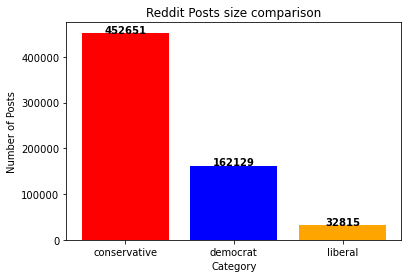

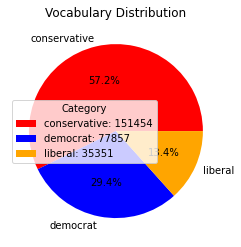

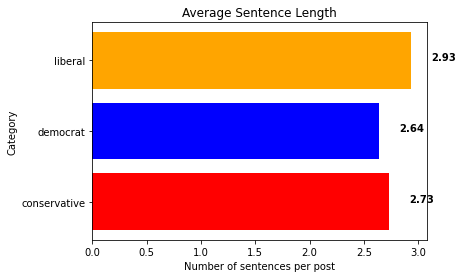

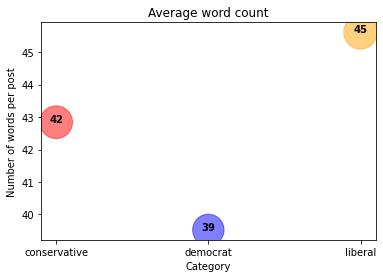

In [9]:
import matplotlib.pyplot as plt
import numpy as np

x = ['conservative', 'democrat', 'liberal']
colors = ['red', 'blue', 'orange']
size = [len(conservative_df['body']), len(democrat_df['body']), len(liberal_df['body'])]
vocab_percent = [conservative_vocab_percent , democrat_vocab_percent, liberal_vocab_percent]
vocab_size = [len(conservative_vocab), len(democrat_vocab), len(liberal_vocab)]
average_sent_length = [np.mean(conservative_df['num_sentences']),
                       np.mean(democrat_df['num_sentences']),
                       np.mean(liberal_df['num_sentences'])]
average_word_count = [np.mean(conservative_df['numWords']),
                      np.mean(democrat_df['numWords']),
                      np.mean(liberal_df['numWords'])]

# post size
plt.bar(x, size, color=colors)
plt.xlabel('Category')
plt.ylabel('Number of Posts')
plt.title('Reddit Posts size comparison')
for i, v in enumerate(size):
    plt.text(i, v + 1, str(v), color='black', fontweight='bold', ha='center')
plt.show()

# vocabulary distribution
chart = plt.pie(vocab_percent, labels=x, autopct='%1.1f%%', colors=colors)
plt.title('Vocabulary Distribution')
legend_labels = []
for i in range(len(vocab_size)):
    legend_labels.append(f"{x[i]}: {vocab_size[i]}")
plt.legend(chart[0], legend_labels, title='Category', loc='center left')
plt.show()

# Sentence length
plt.barh(x, average_sent_length, color=colors)
plt.xlabel('Number of sentences per post')
plt.ylabel('Category')
plt.title('Average Sentence Length')
for i, v in enumerate(average_sent_length):
    plt.text(v + 0.3, i, str(round(v, 2)), color='black', fontweight='bold', ha='center')
plt.show()

# Number of words
plt.scatter(x, average_word_count, s=[a * 25 for a in average_word_count], alpha=0.5, c=colors, cmap='viridis')
plt.xlabel('Category')
plt.ylabel('Number of words per post')
plt.title('Average word count')
for i, v in enumerate(average_word_count):
    plt.text(i, v, str(int(v)), color='black', fontweight='bold', ha='center')
plt.show()


In [14]:
# (word, frequency, score_sum, {doc_ids})
print(get_meta_data(conservative_df))

Row:  nan
The row might be a non string value:  'float' object has no attribute 'strip'
Row:  nan
The row might be a non string value:  'float' object has no attribute 'strip'
                                                     word  freq    score  \
0                                                  'true'  1845  12691.0   
1                                              'probably'  7920  57362.0   
2                                                'public'  7623  56131.0   
3                                               'speaker'   463   3885.0   
4                                          'consistantly'     8     57.0   
...                                                   ...   ...      ...   
151449                                          'yangtze'     1      1.0   
151450   'https://en.wikipedia.org/wiki/jury_nullifica...     1     -2.0   
151451  'https://www.google.com/amp/s/thehill.com/home...     1      5.0   
151452                                            '-show'     1 